<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Оценка-общих-закономерностей-заказов-по-месяцам,-дням-недели-и-часам" data-toc-modified-id="Оценка-общих-закономерностей-заказов-по-месяцам,-дням-недели-и-часам-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Оценка общих закономерностей заказов по месяцам, дням недели и часам</a></span></li><li><span><a href="#Оценка-трендов-и-сезонных-закономерностей-заказов" data-toc-modified-id="Оценка-трендов-и-сезонных-закономерностей-заказов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Оценка трендов и сезонных закономерностей заказов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков-и-подготовка-выборок" data-toc-modified-id="Создание-признаков-и-подготовка-выборок-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков и подготовка выборок</a></span></li><li><span><a href="#Проверка-качества-с-помощью-DummyRegressor" data-toc-modified-id="Проверка-качества-с-помощью-DummyRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Проверка качества с помощью DummyRegressor</a></span></li><li><span><a href="#Обучение-и-тестирование-линейной-регрессии" data-toc-modified-id="Обучение-и-тестирование-линейной-регрессии-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение и тестирование линейной регрессии</a></span></li><li><span><a href="#Обучение-и-тестирование-CatBoost" data-toc-modified-id="Обучение-и-тестирование-CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучение и тестирование CatBoost</a></span></li><li><span><a href="#Обучение-и-тестирование-LGBM" data-toc-modified-id="Обучение-и-тестирование-LGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Обучение и тестирование LGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#импортируем необходимые библиотеки и модули
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [2]:
#загрузим данные и поместим даты в индексы
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = True)

#проверим ряд на монотонность
print(data.index.is_monotonic)

#взглянем на данные
print('Названия столбцов:', data.columns)
display(data.head(5))

#произведем ресемплирование по 1 часу
data = data.resample('1H').sum()
#проверим изменения
data.head(5)

True
Названия столбцов: Index(['num_orders'], dtype='object')


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<b>Вывод:</b> библиотеки и модули импортированы, данные загружены. Временной ряд монотонный. В данных один столбец - фича и один - таргетный. Ресемплирование по одному часу произведено.

## Анализ

### Оценка общих закономерностей заказов по месяцам, дням недели и часам

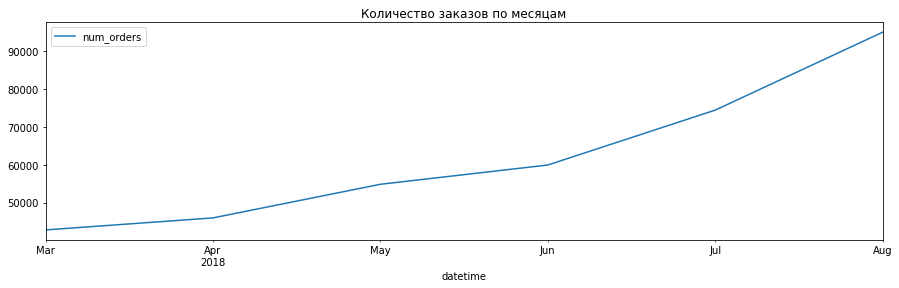

In [3]:
#ресемплируем данные по месяцам и дням и оценим закономерности
data_monthly = data.resample('1M').sum()
data_daily = data.resample('1D').sum()

#посмотрим на кол-во заказов по месяцам
data_monthly.plot(figsize=(15,4))
plt.title('Количество заказов по месяцам')
plt.show()

<b>Вывод:</b> график заказов стабильно растет, в марте отмечается минимум заказов, в августе - максимум. При этом наиболее стремительный рост наблюдается в летние месяцы

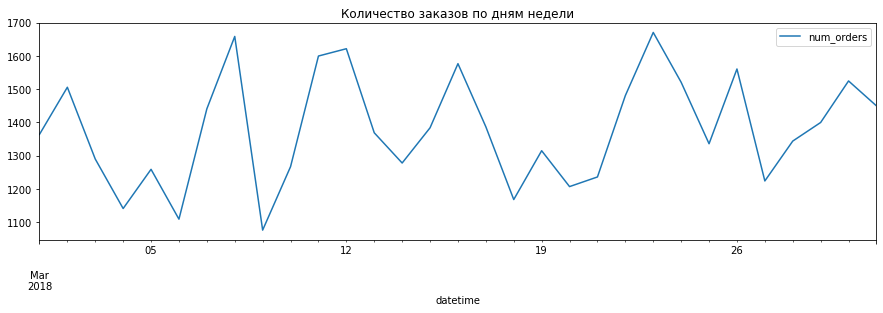

In [4]:
#посмотрим на кол-во заказов в марте по дням недели
data_daily.head(31).plot(figsize=(15,4))
plt.title('Количество заказов по дням недели')
plt.show()

<b>Вывод:</b> график напоминает кардиограмму с цикличными подъемами и спадами в количестве заказов. В марте отмечено 8 дней, когда количество заказов резко падало (4,6,9,14,18,20,25,27) и 10 дней, когда количество заказов резко возрастало (2,5,8,11,12,16,19,23, 26,30). 

Падения заказов происходят по вторникам и воскресеньям, плюс отмечено два "нестандартных" дня - пятница 9 марта (сказывается резкий подъем в честь праздника 8 марта) и среда 14 марта. 

Возрастание заказов стандартно происходит в понедельник и пятницу, плюс отмечен резкий рост заказов в четверг 8 марта (т.к. это праздничный день) и в воскресенье 11 марта.

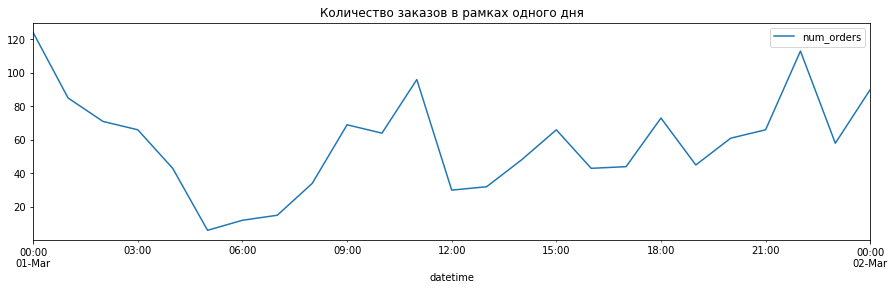

In [5]:
#посмотрим на кол-во заказов по часам в рамках одного дня
data.head(25).plot(figsize=(15,4))
plt.title('Количество заказов в рамках одного дня')
plt.show()

<b>Вывод:</b> выделяется пять "пиков" роста заказов:
- примерно 10.30 утра
- около 15.00
- 18.00
- 22.00-22.30

Количество заказов стабильно снижается после полуночи и примерно до 5 утра, после чего начинается плавное возрастание с небольшим спадом в промежутке 8.30-10.00 утра.После 10.30 и до 13.00 количество заказов падает, затем растет с пиком в точке 15.00 дня, затем снова падает примерно до 17.00, после чего растет с пиком в точке 18.00, после чего падает до 19.00, затем стабильно растет до 22.30. Затем снова начинается спад.
В целом, чередования активности-спада описываются промежутком в 2 часа.
        

Text(0.5, 1.0, 'Скользящее среднее и стандартное отклонение по часовым интервалам')

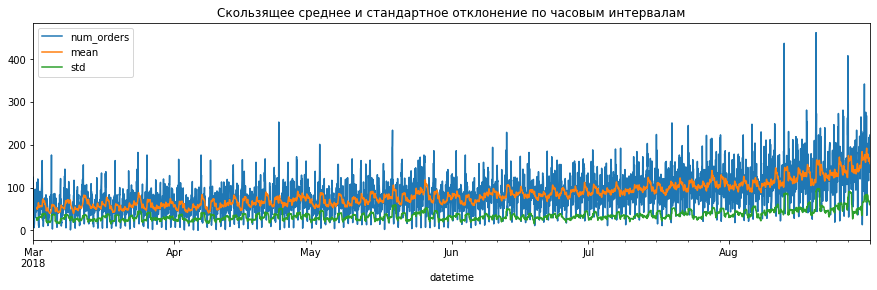

In [6]:
#оценим скользящее среднее и скользящее стандартное отклонение
data['mean'] = data['num_orders'].shift().rolling(20).mean()
data['std'] = data['num_orders'].rolling(20).std()
data.plot(figsize=(15,4))
plt.title('Скользящее среднее и стандартное отклонение по часовым интервалам')

<b>Вывод:</b> среднее растет вместе с общим увеличением числа заказов. Скользящее стандартное отклонение остается на примерно одном и том же уровне.

### Оценка трендов и сезонных закономерностей заказов

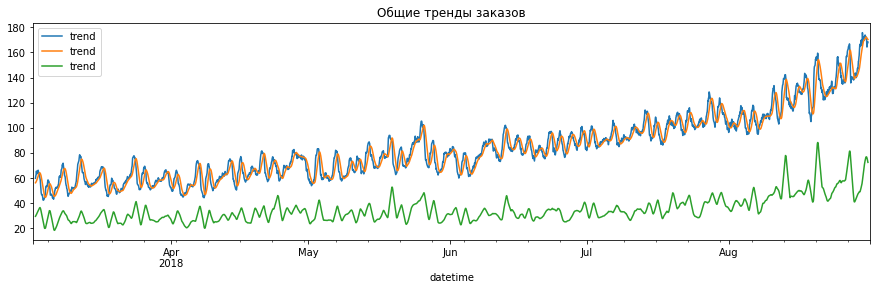

In [7]:
data_copy = data.dropna().copy()
#декомпозируем данные и визуализируем общие тренды
for column in data_copy.columns:
    decomposed_data = seasonal_decompose(data_copy[column])
    decomposed_data.trend.plot(title='Общие тренды заказов', figsize=(15,4), 
                               legend = column)
plt.show()

<b>Вывод:</b> наблюдается тренд к увеличению общего и среднего числа заказов.

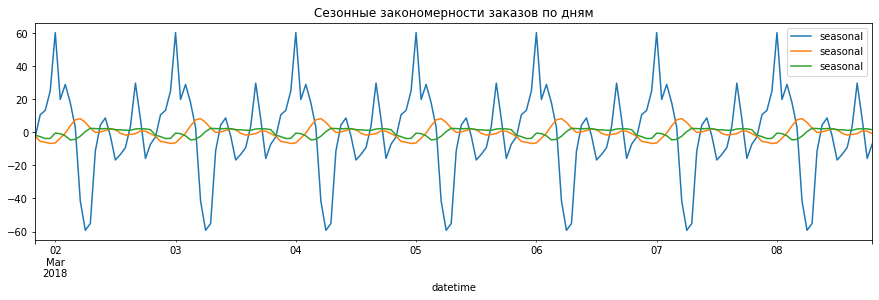

In [8]:
#оценим сезонные закономерности заказов по дням
for column in data_copy.columns:
    decomposed_data = seasonal_decompose(data_copy[column])
    decomposed_data.seasonal.head(24*7).plot(title='Сезонные закономерности заказов по дням',
                                              figsize=(15,4), legend = True)
plt.show()

<b>Вывод:</b> сезонные закономерности цикличны.

PS как еще трактовать это график я не знаю, потому что по идее он должен указывать на различное число заказов в будни и выходные, но тут этого не видно :(
    
    
    

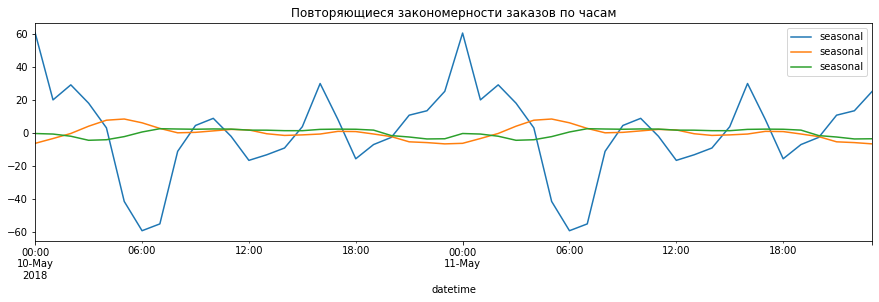

In [9]:
#оценим сезонные закономерности заказов по часам
for column in data_copy.columns:
    decomposed_data = seasonal_decompose(data_copy[column])
    decomposed_data.seasonal['2018-05-10':'2018-05-11'].plot(ax=plt.gca(), 
                                                             figsize=(15,4),
                                                            
                                                            legend = True)
plt.title('Повторяющиеся закономерности заказов по часам')
plt.show()

<b>Вывод:</b> количество заказов с полуночи и до шести утра падает, после - растет с пиками в период 10.30, 15.00, 22.00

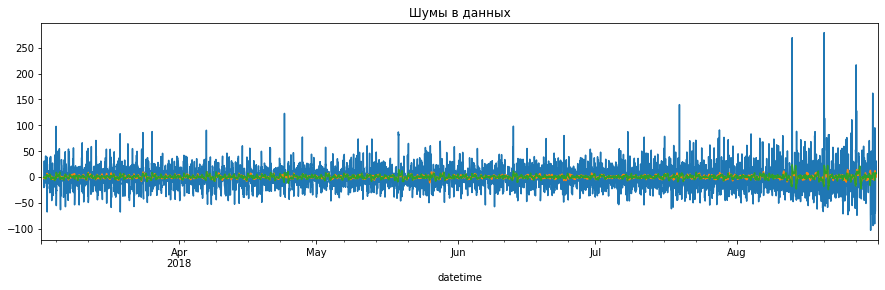

In [10]:
#посмотрим на шумы в данных
for column in data_copy.columns:
    decomposed_data = seasonal_decompose(data_copy[column])
    decomposed_data.resid.plot(title='Шумы в данных', figsize=(15,4))
plt.show()

<b>Вывод</b> шумы распределены более-менее равномерно, в августе их больше

## Обучение

### Создание признаков и подготовка выборок

In [11]:
#создадим признаки для модели
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 10, 10)

#проверим данные
data.describe()

,num_orders,mean,std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
count,4416.000000,4396.000000,4397.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4408.000000,4407.000000,4406.000000,4406.000000
mean,84.422781,84.274932,34.908900,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.236162,84.228954,84.217885,84.316841
std,45.023853,26.893325,11.660756,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,44.831888,44.834421,44.833486,29.695361
min,0.000000,39.550000,14.911934,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000
25%,54.000000,63.087500,26.980061,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.600000
50%,78.000000,80.525000,32.659487,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,80.200000
75%,107.000000,99.850000,39.756198,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,100.700000
max,462.000000,191.950000,97.607417,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,213.400000


In [12]:
#разделим данные на выборки в соотношении 9:1 и удалим пропуски
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

#поделим данные на фичи и таргет
x_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
x_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

#проверим данные
display(train.head(5))
display(test.head(5))
print('Размер обучающей выборки:', len(x_train), len(y_train))
print('Размер тестовой выборки', len(x_test), len(y_test))

,num_orders,mean,std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 20:00:00,61,53.30,24.331645,3,20,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,54.1
2018-03-01 21:00:00,66,50.15,23.246052,3,21,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,53.8
2018-03-01 22:00:00,113,49.20,26.925042,3,22,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,50.8
2018-03-01 23:00:00,58,51.30,26.754045,3,23,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,59.1
2018-03-02 00:00:00,90,50.90,28.056100,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,61.7


,num_orders,mean,std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,140.20,85.995961,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,107.0
2018-08-13 15:00:00,175,141.40,85.124970,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,102.9
2018-08-13 16:00:00,144,146.05,84.376521,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,112.1
2018-08-13 17:00:00,152,148.35,84.320566,0,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,119.9
2018-08-13 18:00:00,104,149.20,84.650675,0,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,131.2


Размер обучающей выборки: 3954 3954
Размер тестовой выборки 442 442


In [13]:
#создадим списки для сохранения результатов работы алгоритмов
algorithms = ['Dummy Regressor', 'Linear Regression', 'CatBoost', 'LGBM']
results = []
education_time = []
prediction_time = []

### Проверка качества с помощью DummyRegressor

In [14]:
#засечем время обучения и обучим модель
start = time.time()
model_dummy = DummyRegressor()
model_dummy.fit(x_train, y_train)
#остановим таймер и зафиксируем результаты
end = time.time()
dummy_education_time = end - start
education_time.append(dummy_education_time)

#засечем время получения предсказаний
start = time.time()
predictions = model_dummy.predict(x_test)
#остановим таймер и зафиксируем результаты
end = time.time()
dummy_prediction_time = end - start
prediction_time.append(dummy_prediction_time)

result = mean_squared_error(predictions, y_test)
print('RMSE случайной модели составляет:', result**0.5)

results.append(result**0.5)

RMSE случайной модели составляет: 84.6528030070785


### Обучение и тестирование линейной регрессии

In [15]:
#объявим модель
model_lr = LinearRegression()

#засечем время обучения и обучим модель
start = time.time()
model_lr.fit(x_train, y_train)
#остановим таймер
end = time.time()
#добавим рез-ты в список
lr_education_time = end - start
education_time.append(lr_education_time)

#засечем время предсказания и получим ответы
start = time.time()
predictions = model_lr.predict(x_test)
end = time.time()
lr_prediction_time = end - start
prediction_time.append(lr_prediction_time)

#рассчитаем RMSE и добавим рез-т в список
result = mean_squared_error(predictions, y_test)
results.append(result**0.5)
print('RMSE линейной регрессии составляет:', result**0.5)

RMSE линейной регрессии составляет: 52.58348923578434


### Обучение и тестирование CatBoost

In [16]:
#объявим объект TimeSeries
tscv = TimeSeriesSplit()
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [23]:
%%time
#объявим модель
cbr = CatBoostRegressor(random_state = 42, loss_function = 'RMSE', verbose = 200)
#добавим тюнинг гиперпараметров для модели и оценим результат
params = {'learning_rate': (0.2, 0.4, 0.6, 0.8), 
          'iterations': [20, 50, 100], 'depth': [4, 6, 8]}

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv= tscv,
                        scoring='neg_root_mean_squared_error',
                        verbose=100)
#grid_cbr.fit(x_train, y_train)
#print(grid_cbr.best_params_)
#print(grid_cbr.best_score_)

CPU times: user 358 µs, sys: 9 µs, total: 367 µs
Wall time: 379 µs


In [18]:
%time
#объявим наилучшую модель CatBoost
best_cbr = CatBoostRegressor(random_state = 42, loss_function = 'RMSE',
                          verbose = 200, depth = 6,
                            iterations = 100, learning_rate = 0.2)
#засечем время и обучим CatBoost
start = time.time()
best_cbr.fit(x_train, y_train)
#остановим таймер и зафиксируем результат
end = time.time()
best_сatboost_education_time = end - start
education_time.append(best_сatboost_education_time)

#засечем время предсказания и получим ответы
start = time.time()
predictions = best_cbr.predict(x_test)
end = time.time()
best_catboost_prediction_time = end - start
prediction_time.append(best_catboost_prediction_time)

#рассчитаем RMSE и добавим рез-т в список
result = mean_squared_error(predictions, y_test)
results.append(result**0.5)
print('RMSE лучшей модели CatBoost составляет:', result**0.5)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs
0:	learn: 35.0203557	total: 3.81ms	remaining: 377ms
99:	learn: 16.9997293	total: 363ms	remaining: 0us
RMSE лучшей модели CatBoost составляет: 43.76561866572522


### Обучение и тестирование LGBM

In [19]:
%time
#объявим модель LGBM без тюнинга гиперпараметров
lgb = LGBMRegressor(random_state = 42, force_row_wise = True, verbose = 500)
#добавим тюнинг гиперпараметров для LGBM и оценим результат
params = {'learning_rate': (0.2, 0.4, 0.6, 0.8),
          'num_leaves': [11, 21, 31, 41]}

grid_lgb = GridSearchCV(lgb,
                        param_grid =params,
                        cv=tscv,
                        scoring='neg_root_mean_squared_error')

#grid_lgb.fit(x_train, y_train)
#print(grid_lgb.best_params_)
#print(grid_lgb.best_score_)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [20]:
%time
#объявим наилучшую модель LGBM
best_lgb = LGBMRegressor(random_state = 42, verbose = 0,
                         force_row_wise= True, 
                         learning_rate = 0.2, num_leaves = 21, n_estimators = 61)

#засечем время и обучим лучшую модель LGBM
start = time.time()
best_lgb.fit(x_train, y_train)
#остановим таймер и зафиксируем результат
end = time.time()
best_lgb_education_time = end - start
education_time.append(best_lgb_education_time)

#засечем время предсказания и получим ответы
start = time.time()
predictions = best_lgb.predict(x_test)
end = time.time()
best_lgb_prediction_time = end - start
prediction_time.append(best_lgb_prediction_time)

#рассчитаем RMSE и добавим рез-т в список
result = mean_squared_error(predictions, y_test)
results.append(result**0.5)
print('RMSE лучшей модели LGBM составляет:', result**0.5)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
RMSE лучшей модели LGBM составляет: 41.458575250576814


## Тестирование

In [21]:
#соберем все показатели в сводную таблицу
#print(results, education_time, prediction_time)
model_estimation = pd.DataFrame(index = ['RMSE модели', 
                                         'Время обучения модели', 'Время предсказания модели'], 
             columns = algorithms)

model_estimation.iloc[0] = results
model_estimation.iloc[1] = education_time
model_estimation.iloc[2] = prediction_time

display(model_estimation)


,Dummy Regressor,Linear Regression,CatBoost,LGBM
RMSE модели,84.652803,52.583489,43.765619,41.458575
Время обучения модели,0.000595,0.003712,1.238278,133.18646
Время предсказания модели,0.000319,0.001544,0.001452,0.088232


Text(0.5, 1.0, 'Сопоставительный график предсказаний лучшей модели и правильных ответов')

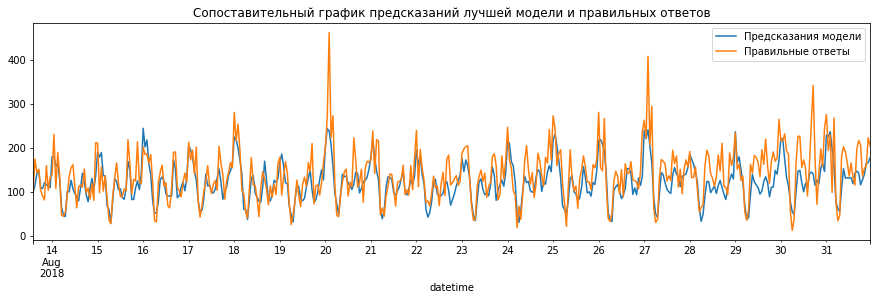

In [22]:
#визуализируем реальные данные и полученные предсказания лучшей модели
pd.Series(index = y_test.index, data = predictions).plot(figsize = (15,4),
                                                         label = 'Предсказания модели',
                                                        legend = True)
y_test.plot(figsize = (15,4), label = 'Правильные ответы',
                                                        legend = True)
plt.title('Сопоставительный график предсказаний лучшей модели и правильных ответов')

<b>Вывод:</b> лучше всего себя показала модель LGBM с RMSE 41

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48